In [179]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fbprophet import Prophet
import altair as alt

In [180]:
url = "../Data/GlobalWarmingAverages.csv"
data = pd.read_csv(url)
data.dropna(inplace=True)
data.reset_index(inplace=True)
# 139 years
data.head()
data.tail()
data = data.drop(columns=['index', '90N', '60N', '30N', '0N', '30S', '60S', '90S'])
data.tail()
#data = data[data.Globe < .85]
data.tail()
data['Year'] = data['Year'].astype(int)
data['Year'] = data['Year'].astype(str)
data['Year'] = pd.to_datetime('01-01-' + data['Year'], format='%m-%d-%Y')
data.columns = ['ds', 'y']
data.tail()
recentdata = data.iloc[130:140]
recentdata.reset_index()

,index,ds,y
0,130,2010-01-01,0.73
1,131,2011-01-01,0.61
2,132,2012-01-01,0.65
3,133,2013-01-01,0.68
4,134,2014-01-01,0.75
5,135,2015-01-01,0.90
6,136,2016-01-01,1.02
7,137,2017-01-01,0.93
8,138,2018-01-01,0.86
9,139,2019-01-01,0.99


In [181]:
def fit_predict_model(dataframe, interval_width = 0.8, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(data)
recent_pred = fit_predict_model(recentdata)

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [182]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,1880-01-01,-0.329187,-0.493995,-0.161115,-0.329187,-0.329187,0.0,0.0,0.0,0.0,0.0,0.0,-0.329187,-0.15
1,1881-01-01,-0.325655,-0.480975,-0.168491,-0.325655,-0.325655,0.0,0.0,0.0,0.0,0.0,0.0,-0.325655,-0.07
2,1882-01-01,-0.322134,-0.471377,-0.171668,-0.322134,-0.322134,0.0,0.0,0.0,0.0,0.0,0.0,-0.322134,-0.09
3,1883-01-01,-0.318613,-0.472082,-0.158648,-0.318613,-0.318613,0.0,0.0,0.0,0.0,0.0,0.0,-0.318613,-0.16
4,1884-01-01,-0.315091,-0.463362,-0.163801,-0.315091,-0.315091,0.0,0.0,0.0,0.0,0.0,0.0,-0.315091,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2015-01-01,0.728125,0.571437,0.878354,0.728125,0.728125,0.0,0.0,0.0,0.0,0.0,0.0,0.728125,0.90
136,2016-01-01,0.743679,0.595992,0.903437,0.743679,0.743679,0.0,0.0,0.0,0.0,0.0,0.0,0.743679,1.02
137,2017-01-01,0.759276,0.610586,0.917495,0.759276,0.759276,0.0,0.0,0.0,0.0,0.0,0.0,0.759276,0.93
138,2018-01-01,0.774831,0.635955,0.924807,0.774831,0.774831,0.0,0.0,0.0,0.0,0.0,0.0,0.774831,0.86


In [183]:

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)
recent_pred = detect_anomalies(recent_pred)

In [184]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)
plot_anomalies(recent_pred)

alt.LayerChart(...)

In [185]:
anomaly_index = pred.loc[pred.anomaly!=0, 'fact'].index
recent_anomaly_index = recent_pred.loc[recent_pred.anomaly!=0, 'fact'].index
recentdata['y'].iloc[recent_anomaly_index] = None
data['y'].iloc[anomaly_index] = None
data

C:\Users\rigby\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,1880-01-01,NaN
1,1881-01-01,NaN
2,1882-01-01,NaN
3,1883-01-01,-0.16
4,1884-01-01,-0.27
...,...,...
135,2015-01-01,NaN
136,2016-01-01,NaN
137,2017-01-01,NaN
138,2018-01-01,0.86


In [186]:
import datetime as dt
future_list = ['01-01-2020', '01-01-2021', '01-01-2022', '01-01-2023', '01-01-2024', '01-01-2025', '01-01-2026', '01-01-2027', '01-01-2028', '01-01-2029', '01-01-2030', '01-01-2031', '01-01-2032', '01-01-2033', '01-01-2034', '01-01-2035', '01-01-2036', '01-01-2037', '01-01-2038', '01-01-2039', '01-01-2040', '01-01-2041',
              '01-01-2042', '01-01-2043', '01-01-2044', '01-01-2045', '01-01-2046', '01-01-2047', '01-01-2048', '01-01-2049', '01-01-2050']
future = pd.DataFrame(data= future_list, columns = ['ds'])
future.ds = pd.to_datetime(future.ds)
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 1 columns):
ds    31 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 376.0 bytes


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


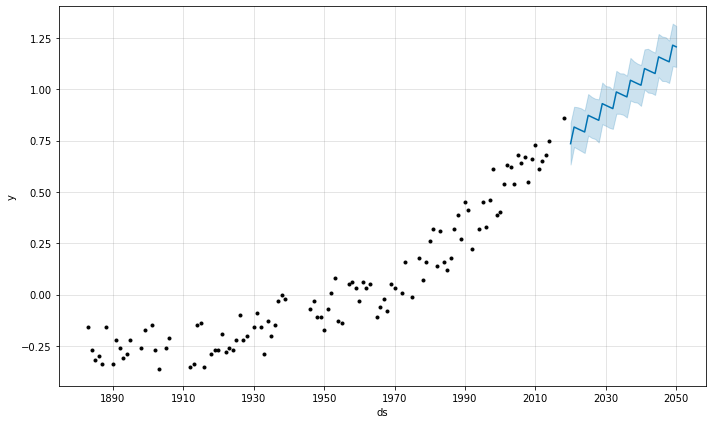

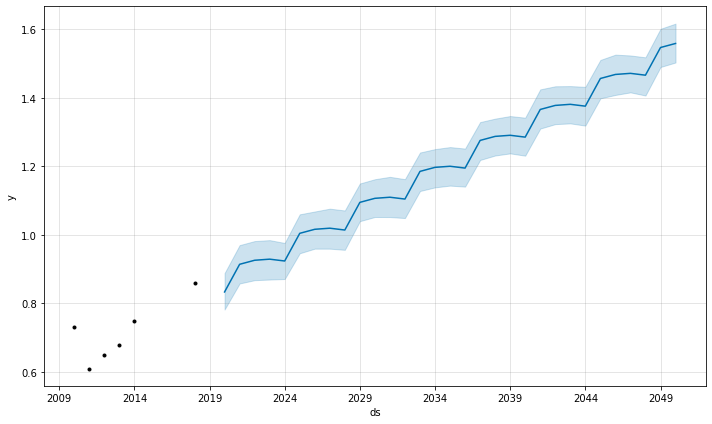

In [187]:
model = Prophet().fit(data)
recent_model = Prophet().fit(recentdata)
fig = model.plot(model.predict(future))
fig2 = recent_model.plot(recent_model.predict(future))


In [190]:
recent_predictions = recent_model.predict(future)
predictions = model.predict(future)

In [195]:


#predictions = predictions.drop(columns=['trend', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper'])
predictions
#recent_predictions = recent_predictions.drop(columns=['trend', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper'])
recent_predictions

,ds,yhat_lower,yhat_upper,yhat
0,2020-01-01,0.638505,0.839386,0.734940
1,2021-01-01,0.718690,0.909871,0.815975
2,2022-01-01,0.704808,0.911425,0.807788
3,2023-01-01,0.700942,0.898661,0.799748
4,2024-01-01,0.695628,0.895688,0.791880
5,2025-01-01,0.769428,0.968178,0.872915
6,2026-01-01,0.760678,0.964542,0.864728
7,2027-01-01,0.752527,0.961099,0.856688
8,2028-01-01,0.749146,0.950052,0.848820
9,2029-01-01,0.832479,1.028874,0.929855


In [203]:
url = "../Data/GlobalWarmingAverages.csv"
maindf = pd.read_csv(url)
maindf.dropna(inplace=True)
maindf.reset_index(inplace=True)
maindf = maindf.drop(columns=['index', '90N', '60N', '30N', '0N', '30S', '60S', '90S'])
maindf['Year'] = maindf['Year'].astype(int)
maindf['Year'] = maindf['Year'].astype(str)
maindf['Year'] = pd.to_datetime('01-01-' + maindf['Year'], format='%m-%d-%Y')
maindf

,Year,Globe
0,1880-01-01,-0.15
1,1881-01-01,-0.07
2,1882-01-01,-0.09
3,1883-01-01,-0.16
4,1884-01-01,-0.27
...,...,...
135,2015-01-01,0.90
136,2016-01-01,1.02
137,2017-01-01,0.93
138,2018-01-01,0.86


In [209]:
bothdfs = [maindf, recent_predictions]
bothfinaldfs = [maindf, predictions]
maindf.columns = ['ds', 'yhat']
recent_final = pd.concat(bothdfs, axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
recent_final.to_csv("../Data/GlobalWarmingRecentPredictions.csv")

final = pd.concat(bothfinaldfs, axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
final.to_csv("../Data/GlobalWarmingHistoricalPredictions.csv")

C:\Users\rigby\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\rigby\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


